## Import OGER output

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%%time

import pandas as pd
import seaborn as sns
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 1.45 s, sys: 666 ms, total: 2.12 s
Wall time: 44.6 s


In [3]:
%%time
cols = ['BiosampleId', 'Biolink', 'BeginTerm', 'EndTerm', 'TokenizedTerm', 'PreferredTerm', 'CURIE', 'NaN1', 'S-Type', 'NaN2', 'UMLS_CUI']
ogerOutput = pd.read_csv('../nlpOutput/FullNLPOutput-EnvoNcbiTaxon.tsv', sep='\t', names=cols )
ogerOutput = ogerOutput.drop(['NaN1', 'NaN2', 'UMLS_CUI'], axis = 1)
print('Total number of rows: ', str(len(ogerOutput)))
ogerOutput.head()
#pd.set_option("display.max_rows", None)
#print(ogerOutput.CURIE.value_counts())

Total number of rows:  17518791


,BiosampleId,Biolink,BeginTerm,EndTerm,TokenizedTerm,PreferredTerm,CURIE,S-Type
0,SAMN10586215,biolink:OrganismalEntity,0,4,This,This,NCBITaxon:169495,S1
1,SAMN10586215,biolink:OntologyClass,16,24,contains,contains,RO:0001019,S1
2,SAMN10586215,biolink:OrganismalEntity,51,55,data,Data,NCBITaxon:1369087,S1
3,SAMN10586215,biolink:OrganismalEntity,72,82,Salmonella,Salmonella,NCBITaxon:590,S1
4,SAMN10586215,biolink:OrganismalEntity,119,127,Bacteria,Bacteria,NCBITaxon:2,S1


### Functions

In [5]:
'''
Chart Plot functions
'''

def annotatePlot(axs, yLim, valueAngle=0, xyDist=20):
    for p in axs.patches:
             axs.annotate("%.d" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='center', fontsize=20, color='black', xytext=(0, xyDist),
                 textcoords='offset points', rotation = valueAngle)
    _ = axs.set_ylim(0,yLim) #To make space for the annotations

def drawPlot(ontology, topTermCount=50):
    termOntoEnvo = termOnto[termOnto.CURIE == ontology]
    sns.set(rc={'figure.figsize':(20,8)})
    axs = sns.countplot(x = termOntoEnvo.TokenizedTerm, data = termOntoEnvo, order=termOntoEnvo.TokenizedTerm.value_counts().iloc[:topTermCount].index)
    axs.set_title('Top '+str(topTermCount)+' terms from ' + ontology, fontsize=30)
    axs.set_xlabel("Terms",fontsize=20)
    axs.set_ylabel("Counts",fontsize=20)
    axs.tick_params(labelsize=20)
    axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
    
    return axs
    
'''
    Function to phrase-ify: Form Phrases for each biosample
    Phrase = list of all terms recognized by OGER
'''

def phrasify(dataFrame, columnNames):
    count = 0
    returnDF = pd.DataFrame(columns=columnNames)
    
    bsIdList = dataFrame.BiosampleId.unique()
    
    for i in bsIdList:
        count += 1
        tmpDF = pd.DataFrame()
        bpList = []
        phrase1 = []
        phrase2 = []
        curie = []

        tmpDF = dataFrame.loc[(dataFrame.BiosampleId == i)]
        
        # Filter: Consider ONLY 3 or more DISTINCT terms AND if an RO CURIE is present
        
        #if len(tmpDF) > 2 \
        #and len(tmpDF.TokenizedTerm.unique()) > 2 \
        #and tmpDF.CURIE.str.contains('RO').any():
            
        tmpDF.sort_values(by=['BeginTerm'], inplace=True)

        for row in tmpDF.iterrows():
            bpList.append(row[1].BeginTerm)
            phrase1.append(row[1].TokenizedTerm)
            phrase2.append(row[1].PreferredTerm)
            curie.append(row[1].CURIE)

        returnDF = returnDF.append(pd.DataFrame([[i, bpList, phrase1, phrase2, curie]], columns=columnNames))
            
        if count % 1000 == 0:
            print('Number of relevant rows: '+ str(len(returnDF))+ ' - '+ datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
        # *********** FOR DEBUG PURPOSES ONLY ****************
        #if count == 5000:
        #    break;
        
    return returnDF

## NLP output breakdown

In [6]:
%%time
termOnto = ogerOutput[['TokenizedTerm', 'PreferredTerm', 'CURIE']]
termOnto.CURIE = termOnto['CURIE'].str.split(':').map(lambda x: x[0])
termOnto.TokenizedTerm = termOnto.TokenizedTerm.str.lower()
termOnto.head()

CPU times: user 30 s, sys: 4.16 s, total: 34.2 s
Wall time: 37.8 s


,TokenizedTerm,PreferredTerm,CURIE
0,this,This,NCBITaxon
1,contains,contains,RO
2,data,Data,NCBITaxon
3,salmonella,Salmonella,NCBITaxon
4,bacteria,Bacteria,NCBITaxon


CPU times: user 18.5 s, sys: 1.1 s, total: 19.6 s
Wall time: 19.8 s


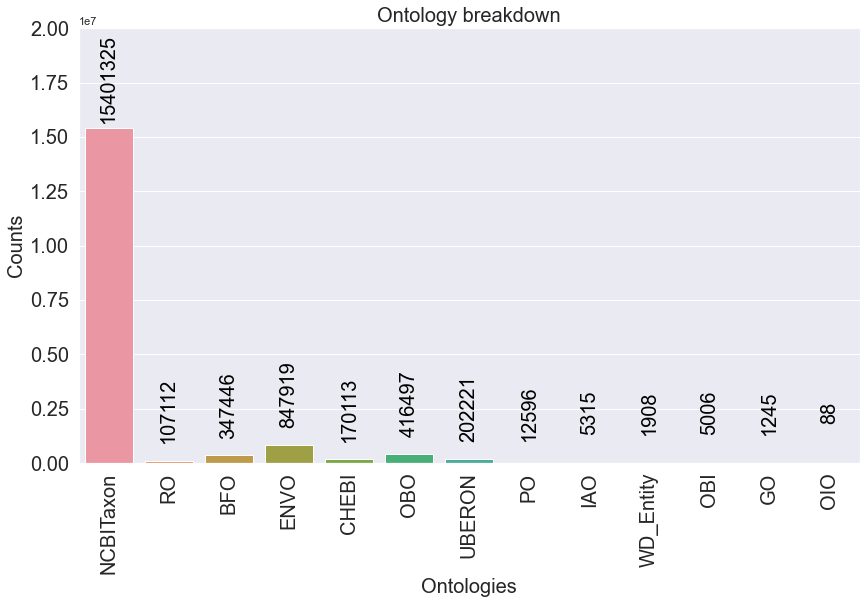

In [14]:
%%time
sns.set(rc={'figure.figsize':(14,8)})
nlpAx = sns.countplot(x = termOnto.CURIE, data = termOnto)
nlpAx.set_title('Ontology breakdown', fontsize=20)
nlpAx.set_xlabel("Ontologies",fontsize=20)
nlpAx.set_ylabel("Counts",fontsize=20)
nlpAx.tick_params(labelsize=20)
nlpAx.set_xticklabels(nlpAx.get_xticklabels(), rotation=90)

annotatePlot(nlpAx, 20000000, 90, 50)

## ENVO

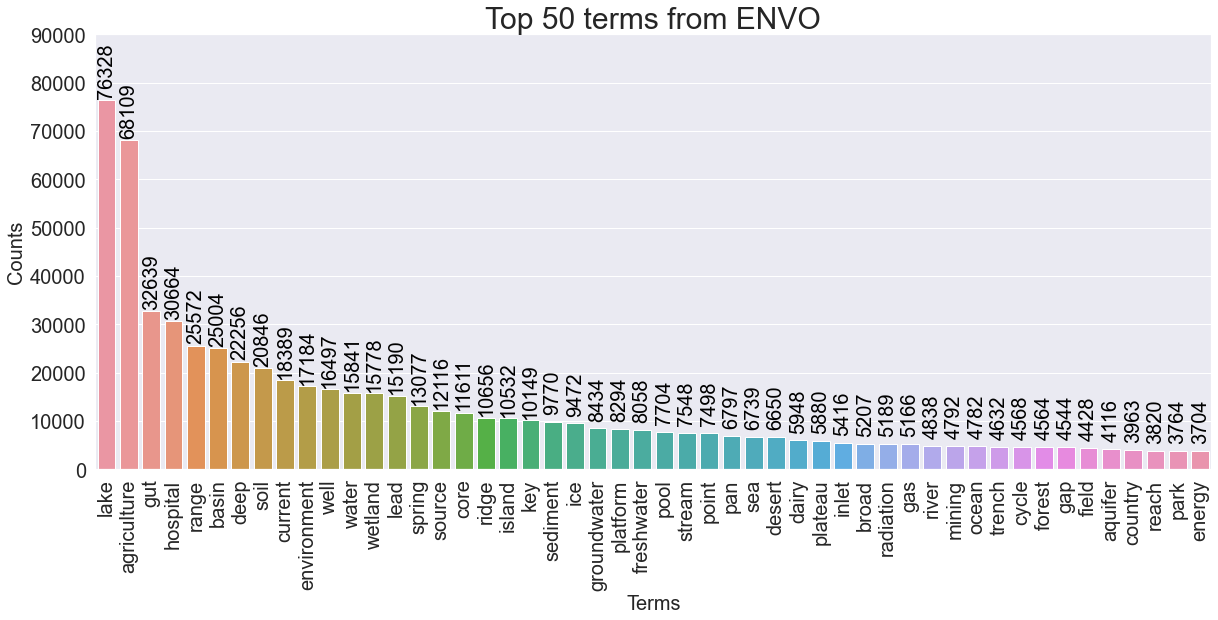

In [15]:
nlpEnvoAx = drawPlot('ENVO')
annotatePlot(nlpEnvoAx, 90000, 90, 30)


## OBO

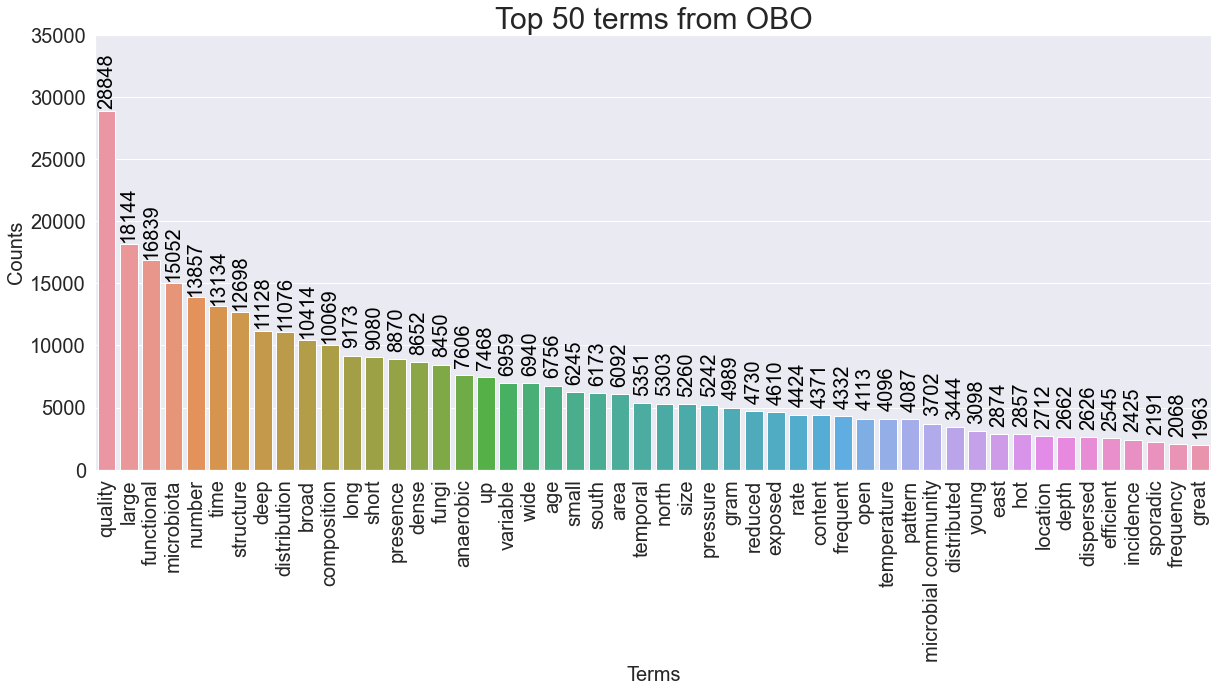

In [16]:
nlpOboAx = drawPlot('OBO')
annotatePlot(nlpOboAx, 35000, 90, 30)


## RO

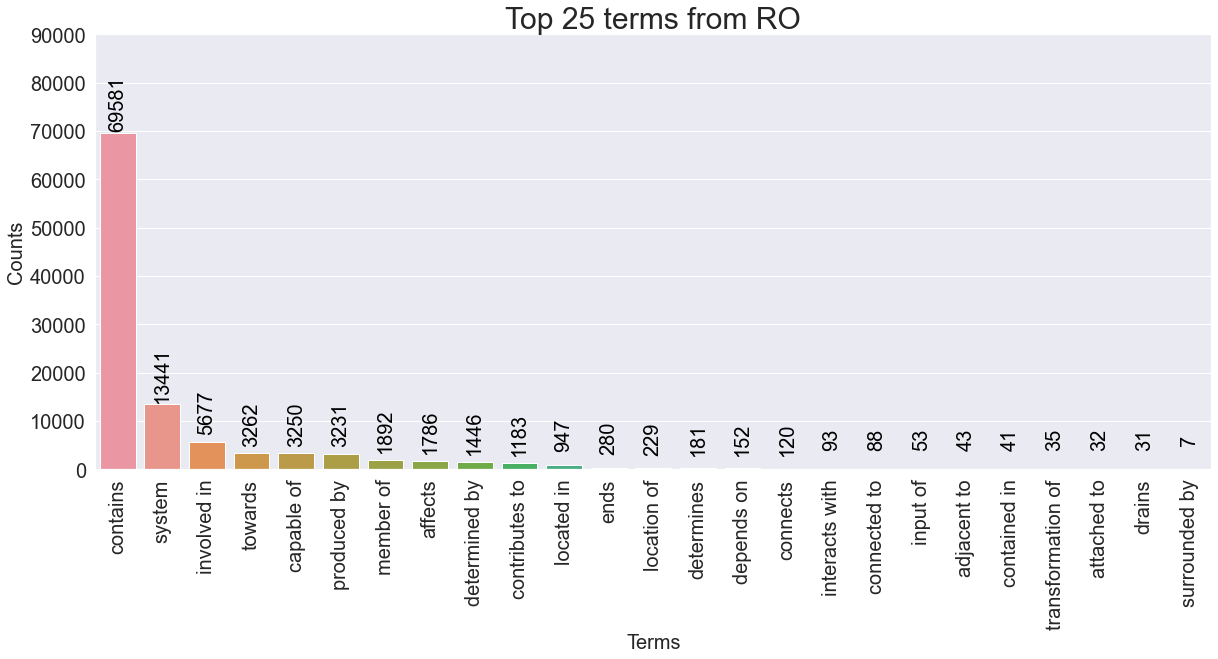

In [17]:
nlpRoAx = drawPlot('RO', 25)
annotatePlot(nlpRoAx, 90000, 90, 30)


## NCBITaxon

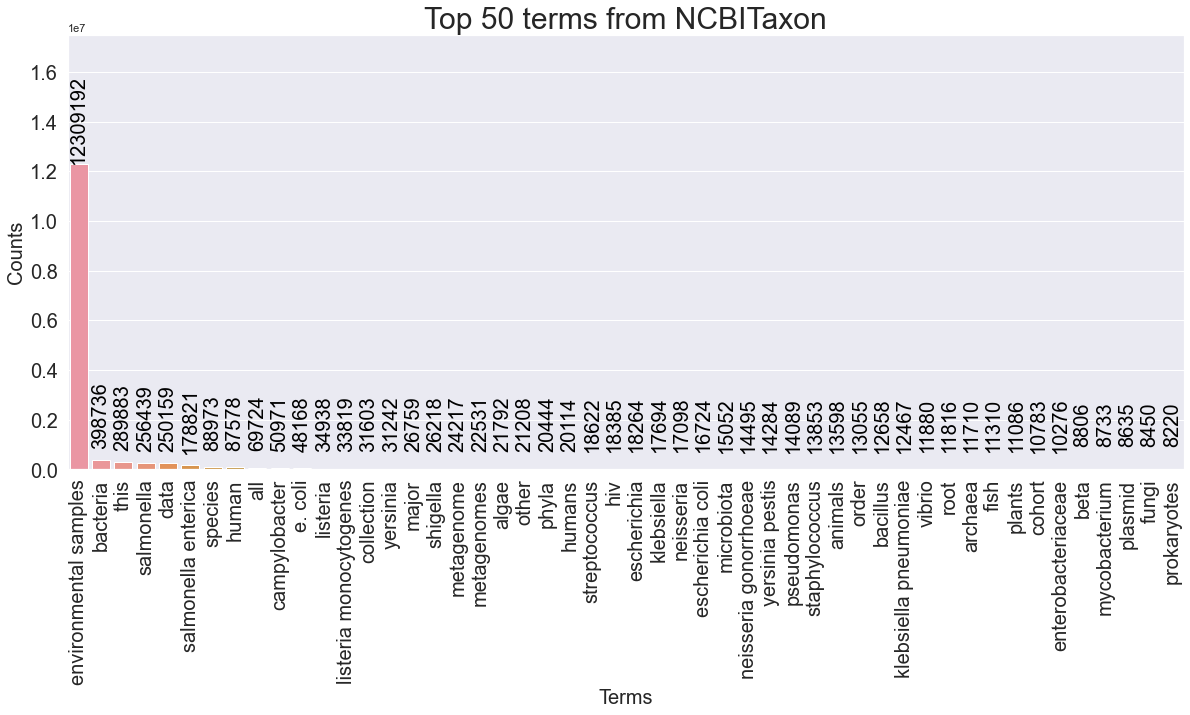

In [21]:
nlpNcbiAx = drawPlot('NCBITaxon')
annotatePlot(nlpNcbiAx, 17500000, 90, 45)


## BFO

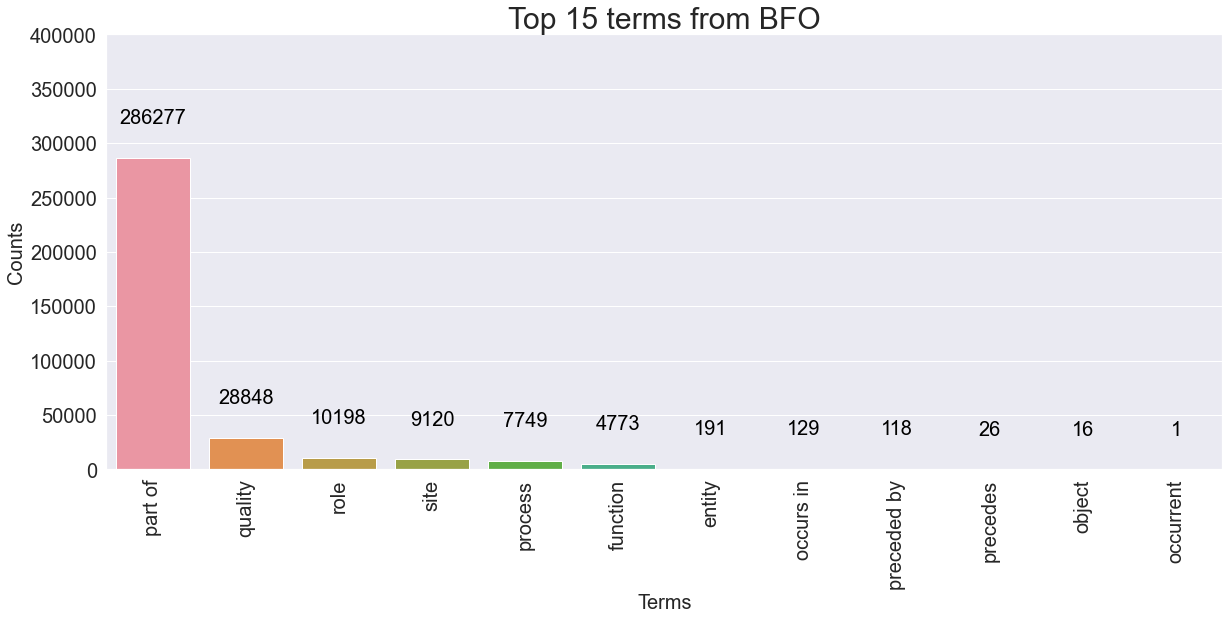

In [23]:
nlpBfoAx = drawPlot('BFO', 15)
annotatePlot(nlpBfoAx, 400000, 0, 40)


## CHEBI

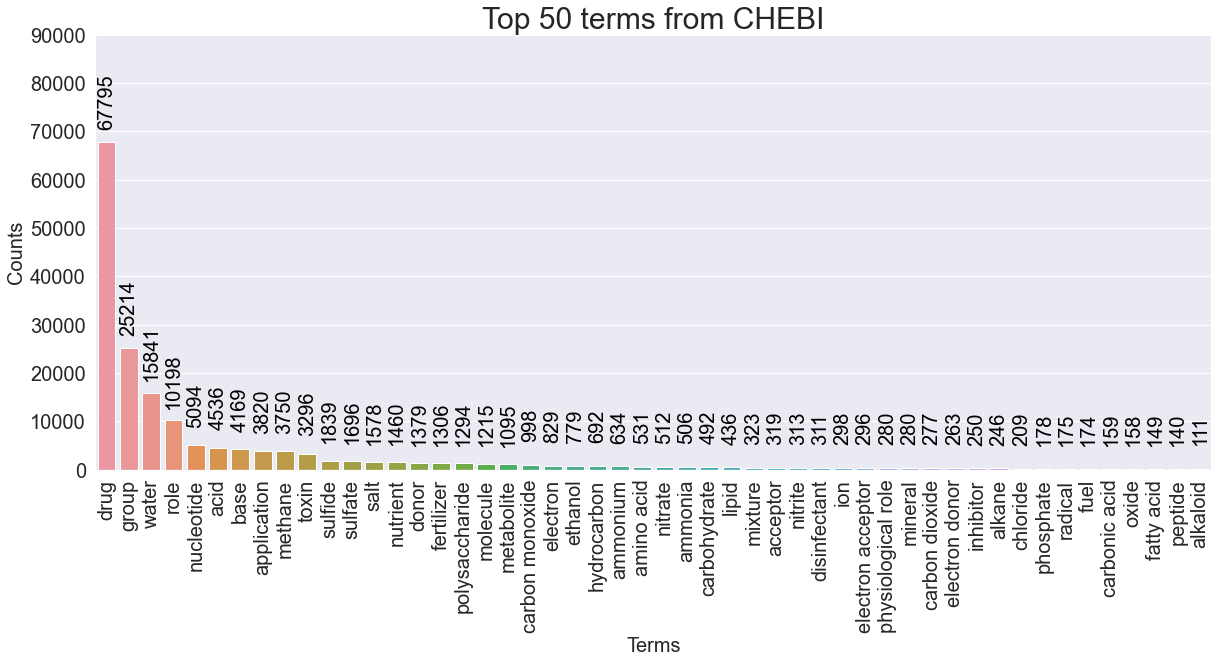

In [25]:
nlpCheAx = drawPlot('CHEBI')
annotatePlot(nlpCheAx, 90000, 90, 40)


## UBERON

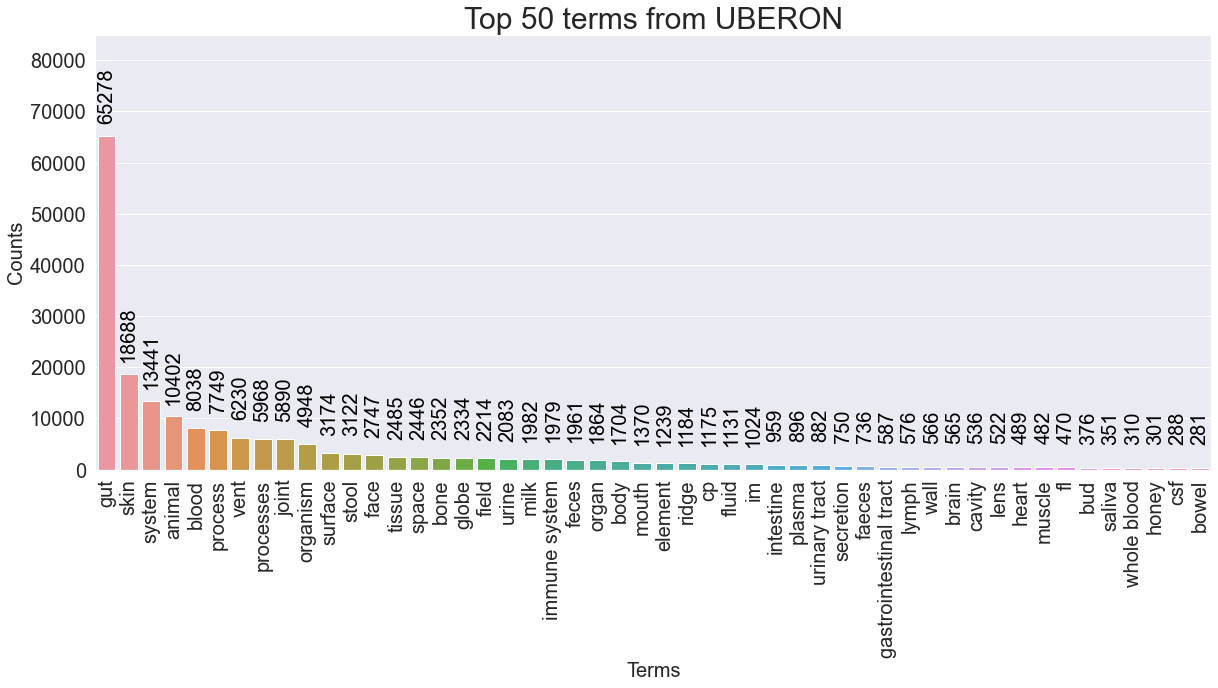

In [36]:
nlpUbeAx = drawPlot('UBERON')
annotatePlot(nlpUbeAx, 85000, 90, 40)


## PO

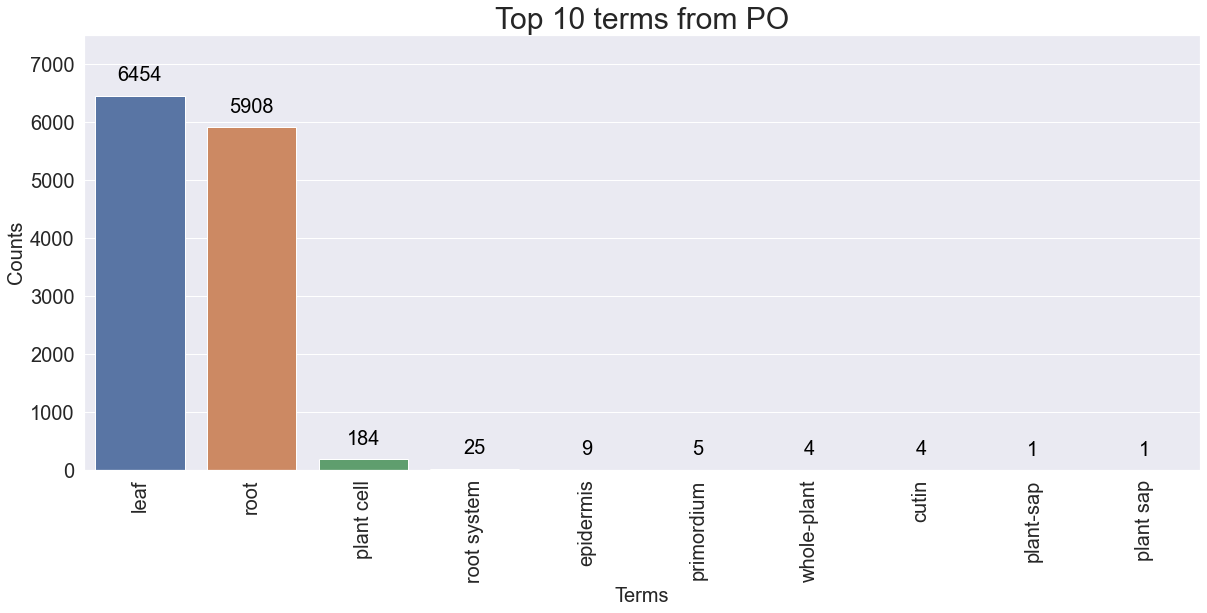

In [27]:
nlpUbeAx = drawPlot('PO', 10)
annotatePlot(nlpUbeAx, 7500, 0, 20)


## IAO

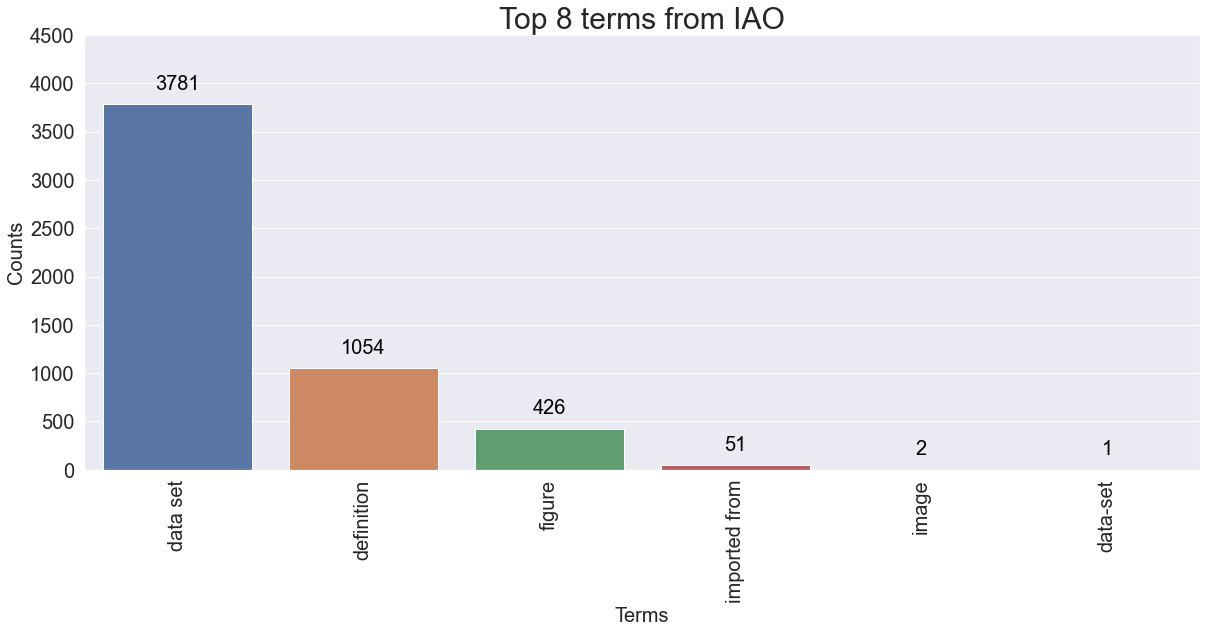

In [28]:
nlpIaoAx = drawPlot('IAO', 8)
annotatePlot(nlpIaoAx, 4500, 0, 20)


## WD_Entity

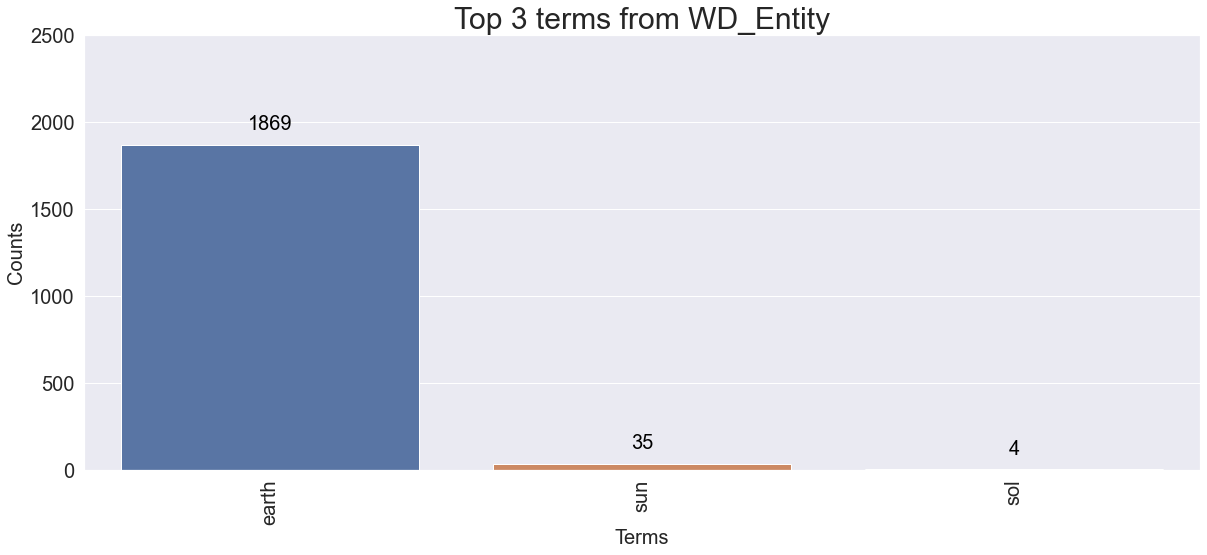

In [29]:
nlpWdeAx = drawPlot('WD_Entity', 3)
annotatePlot(nlpWdeAx, 2500, 0, 20)


## OBI

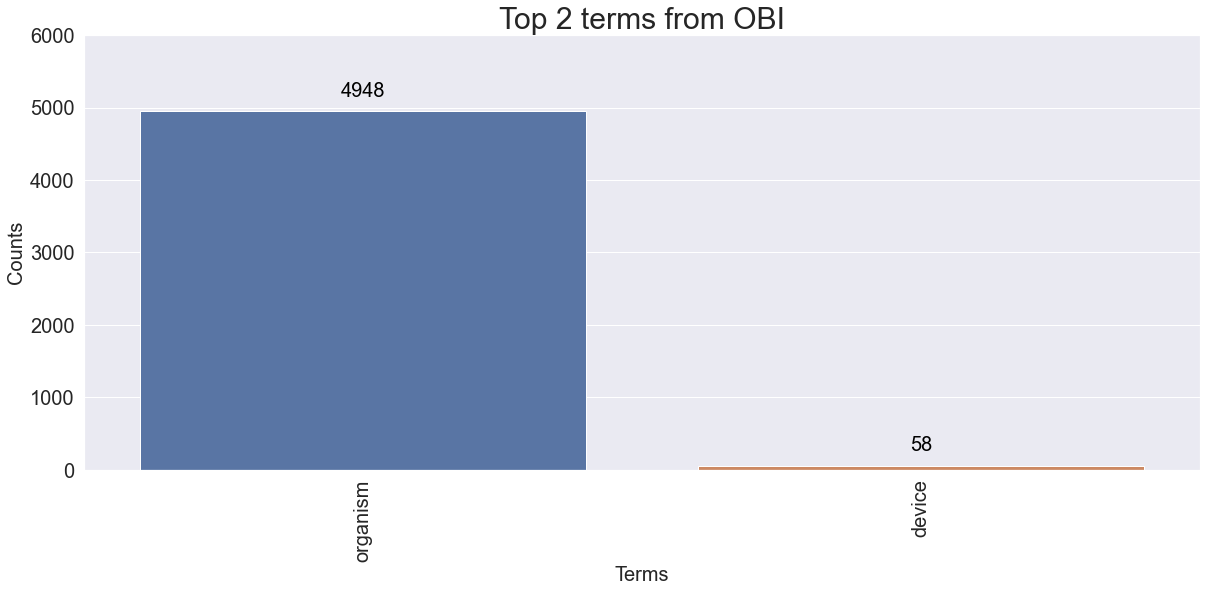

In [31]:
nlpObiAx = drawPlot('OBI', 2)
annotatePlot(nlpObiAx, 6000, 0, 20)


## GO

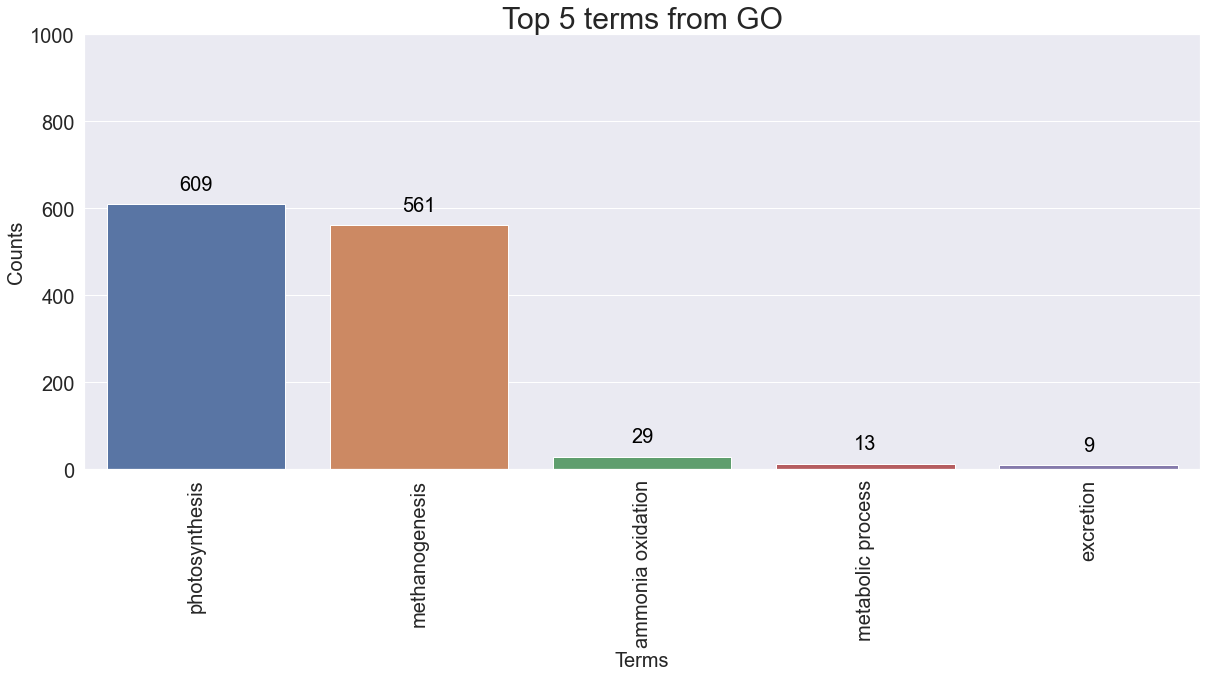

In [32]:
nlpGoAx = drawPlot('GO', 5)
annotatePlot(nlpGoAx, 1000, 0, 20)


## OIO

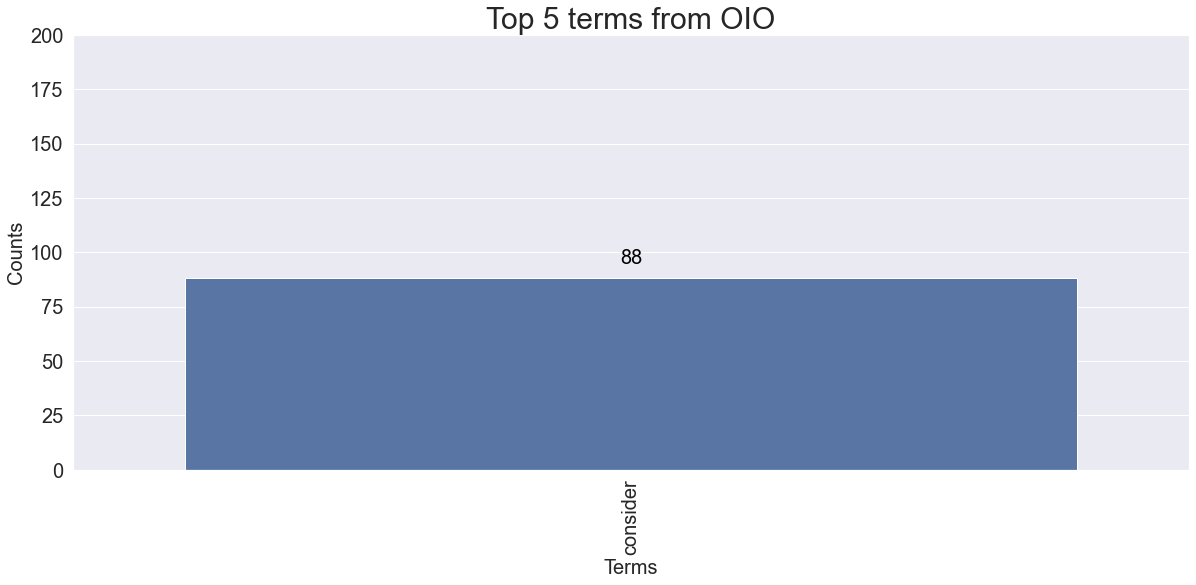

In [35]:
nlpOioAx = drawPlot('OIO', 5)
annotatePlot(nlpOioAx, 200, 0, 20)


## Import OGER Input

In [37]:
ogerInput = pd.read_csv('../output/biosampleDescriptionDF.tsv', sep='\t')
ogerInput.BiosampleId = ogerInput.BiosampleId.map(lambda x: x.replace('BIOSAMPLE:',''))
ogerInput = ogerInput.drop(['StudyId', 'Name', 'Title'], axis = 1)
print('Number of rows: '+ str(len(ogerInput)))
print('Number of unique Ids: '+ str(len(ogerInput.BiosampleId.unique())))
print('Number of unique Desc: '+ str(len(ogerInput.Description.unique())))
ogerInput = ogerInput.drop_duplicates()
print('******After duplicate row removal*****')
print('Number of rows: '+ str(len(ogerInput)))
print('Number of unique Ids: '+ str(len(ogerInput.BiosampleId.unique())))
print('Number of unique Description: '+ str(len(ogerInput.Description.unique())))
ogerInput.head()

Number of rows: 948401
Number of unique Ids: 938333
Number of unique Desc: 59789
******After duplicate row removal*****
Number of rows: 947374
Number of unique Ids: 938333
Number of unique Description: 59789


,Description,BiosampleId
0,Treponema denticola ATCC 35405. Treponema dent...,SAMN02603967
1,Treponema pallidum subsp. pallidum. This organ...,SAMN02604348
2,Campylobacter fetus subsp. venerealis str. Azu...,SAMN02471365
3,Campylobacter jejuni strain NCTC11168. This st...,SAMEA1705929
4,Francisella tularensis subsp. tularensis strai...,SAMEA3138185


In [38]:
# Serching for negation in a very naive fashion

searchfor = [' not ', 'fail', 'absent', 'negative']
test = ogerInput.where(lambda x: x.Description.str.contains('|'.join(searchfor))).dropna()

test.drop_duplicates().head()


,Description,BiosampleId
1,Treponema pallidum subsp. pallidum. This organ...,SAMN02604348
12,Sinorhizobium meliloti strain 1021. Streptomyc...,SAMEA3283068
13,Methylobacterium extorquens strain AM1. This s...,SAMN02604258
17,Bordetella bronchiseptica strain RB50. This st...,SAMEA1705943
18,Bordetella parapertussis strain 12822 . This s...,SAMEA1705915


In [39]:
print('Unique BiosampleIds: '+ str(len(ogerOutput.BiosampleId.unique())))
print('Unique CURIEs: '+ str(len(ogerOutput.CURIE.unique())))
print('Unique Biolinks: '+ str(len(ogerOutput.Biolink.unique())))
print('Unique Standard Terms: '+ str(len(ogerOutput.PreferredTerm.unique())))

Unique BiosampleIds: 939016
Unique CURIEs: 32825
Unique Biolinks: 4
Unique Standard Terms: 32820


In [ ]:
'''curieOfInterest = ['ENVO', 'PATO', 'RO']
envoPato = ogerOutput[ogerOutput.CURIE.str.contains('|'.join(curieOfInterest))]
print('Number of rows: '+ str(len(envoPato)))
envoPato.head()'''

In [ ]:
'''salineTerms = ['sali', 'salt']
envPatSal = envoPato[envoPato.TokenizedTerm	.str.contains('|'.join(salineTerms))]
print('Number of rows: '+ str(len(envPatSal)))
envPatSal.head()'''

In [42]:
# Get list of IDs from structured data file

fp = '../input/water-related-samples.tsv.gz'
#fp = '../input/non-human-samples.tsv.gz'

structuredDataDF = pd.read_csv(fp, sep='\t', low_memory=False)
print('Number of rows: ', str(len(structuredDataDF)))
structuredDataDF.head()

Number of rows:  18615


,tot_diss_nitro,salinity_meth,tidal_stage,num_replicons,nitrate,rel_to_oxygen,potassium,sodium,env_package,biomass,...,depth,silicate,tot_part_carb,trophic_level,calcium,id,taxonomy_id,taxonomy_name,package,norm_env_package
0,NaN,NaN,NaN,NaN,NaN,NaN,2.33,NaN,water,NaN,...,NaN,NaN,NaN,NaN,87.66,BIOSAMPLE:SAMEA1706329,449393,freshwater metagenome,Generic.1.0,water
1,NaN,NaN,NaN,NaN,NaN,NaN,1.33,NaN,water,NaN,...,NaN,NaN,NaN,NaN,62.28,BIOSAMPLE:SAMEA1706311,449393,freshwater metagenome,Generic.1.0,water
2,NaN,NaN,NaN,NaN,NaN,NaN,2.77,NaN,water,NaN,...,NaN,NaN,NaN,NaN,87.05,BIOSAMPLE:SAMEA1706320,449393,freshwater metagenome,Generic.1.0,water
3,NaN,NaN,NaN,NaN,NaN,NaN,2.52,NaN,water,NaN,...,NaN,NaN,NaN,NaN,126.11,BIOSAMPLE:SAMEA1706300,449393,freshwater metagenome,Generic.1.0,water
4,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,water,NaN,...,NaN,NaN,NaN,NaN,332.17,BIOSAMPLE:SAMEA1706316,449393,freshwater metagenome,Generic.1.0,water


### Get OGER data corresponding to the ones present in structured data

#### From OGER Input

In [43]:
structDataID = structuredDataDF.id.str.replace('BIOSAMPLE:','')
structDataIdDF = pd.DataFrame(structDataID)
structDataOgerInput = ogerInput.merge(structDataIdDF, how='inner', left_on='BiosampleId', right_on='id')
structDataOgerInput = structDataOgerInput.drop(['id'], axis = 1)
print('Number of rows: '+ str(len(structDataOgerInput)))
structDataOgerInput.head()


Number of rows: 243


,Description,BiosampleId
0,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228699
1,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228700
2,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228701
3,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228702
4,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228703


#### From OGER output

In [44]:
structDataOgerOutput = ogerOutput.merge(structDataIdDF, how='inner', left_on='BiosampleId', right_on='id')
structDataOgerOutput = structDataOgerOutput.drop(['id'], axis = 1)
print('Number of row: '+ str(len(structDataOgerOutput)))
structDataOgerOutput.head()


Number of row: 8612


,BiosampleId,Biolink,BeginTerm,EndTerm,TokenizedTerm,PreferredTerm,CURIE,S-Type
0,SAMN02393652,biolink:ChemicalSubstance,19,24,probe,probe,CHEBI:50406,S1
1,SAMN02393652,biolink:OntologyClass,61,65,soil,soil,ENVO:00001998,S1
2,SAMN02393652,biolink:AnatomicalEntity,70,73,gut,digestive tract,UBERON:0001555,S1
3,SAMN02393652,biolink:OntologyClass,70,73,gut,watercourse,ENVO:00000029,S1
4,SAMN02393652,biolink:AnatomicalEntity,70,73,gut,digestive system,UBERON:0001007,S1


In [45]:
%%time

pCols = ['BiosampleId', 'BeginPosList', 'Phrase', 'StdPhrase', 'CURIE']
phraseDF = phrasify(structDataOgerOutput,pCols)
print('*****Number of rows: '+ str(len(phraseDF)) + ' ********')
phraseDF.head()


*****Number of rows: 243 ********
CPU times: user 2.05 s, sys: 19.3 ms, total: 2.07 s
Wall time: 2.19 s


,BiosampleId,BeginPosList,Phrase,StdPhrase,CURIE
0,SAMN02393652,"[19, 61, 70, 70, 70, 208]","[probe, soil, gut, gut, gut, function]","[probe, soil, digestive tract, watercourse, di...","[CHEBI:50406, ENVO:00001998, UBERON:0001555, E..."
0,SAMN02389811,"[20, 48, 166, 179, 189, 202, 202, 221, 221, 24...","[aquarium, mesocosm, This, part of, flow, syst...","[aquarium, mesocosm, This, part of, mass wasti...","[ENVO:00002196, ENVO:01000620, NCBITaxon:16949..."
0,SAMN02251077,"[65, 65, 65, 98, 162, 188, 198, 216, 231, 259,...","[bacteria, bacteria, bacteria, lagoon, this, s...","[Bacteria, Bacteria, Bacteria Latreille et al....","[NCBITaxon:2, NCBITaxon:2, NCBITaxon:629395, E..."
0,SAMEA2620360,"[42, 80, 160, 178, 200, 200, 231, 231]","[seawater, Tara, Ocean, This, all, all, qualit...","[sea water, Tara, ocean, This, root, root, qua...","[ENVO:00002149, NCBITaxon:508957, ENVO:0000001..."
0,SAMN02009298,"[63, 63, 63, 68, 89, 93, 138, 143, 201, 236, 4...","[deep, deep, deep, sea, Sea, rift, halo, strat...","[undersea trough, ocean trench, increased dept...","[ENVO:01000654, ENVO:00000275, OBO:PATO_000159..."


In [46]:
# Join with ogerInput to get the description

phraseWithDescDF = phraseDF.merge(structDataOgerInput, how='right', on='BiosampleId').dropna()
print('*****Number of rows: '+ str(len(phraseWithDescDF)) + ' ********')
phraseWithDescDF.head()

*****Number of rows: 242 ********


,BiosampleId,BeginPosList,Phrase,StdPhrase,CURIE,Description
0,SAMN02228699,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
1,SAMN02228700,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
2,SAMN02228701,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
3,SAMN02228702,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
4,SAMN02228703,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...


In [48]:
# Add prefix 'BIOSAMPLE:' to the id 
phraseWithDescDF.BiosampleId = 'BIOSAMPLE:' + phraseWithDescDF.BiosampleId
phraseWithDescDF.head()

,BiosampleId,BeginPosList,Phrase,StdPhrase,CURIE,Description
0,BIOSAMPLE:SAMN02228699,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
1,BIOSAMPLE:SAMN02228700,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
2,BIOSAMPLE:SAMN02228701,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
3,BIOSAMPLE:SAMN02228702,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...
4,BIOSAMPLE:SAMN02228703,"[82, 82, 93, 104, 104, 104, 104, 104, 104, 104...","[sink, sink, located in, Lake, Lake, Lake, Lak...","[sink fixture, sinkhole, located in, pond, int...","[ENVO:01000990, ENVO:00000195, RO:0001025, ENV...",Purple microbial (Photo- and chemosynthetic) m...


In [49]:
#result = ogerInput.merge(phraseDF, how='inner', on='BiosampleId')
result = structuredDataDF.merge(phraseWithDescDF, how='left', left_on='id', right_on='BiosampleId')
print('Number of rows: '+ str(len(result)))
result.head()

Number of rows: 18617


,tot_diss_nitro,salinity_meth,tidal_stage,num_replicons,nitrate,rel_to_oxygen,potassium,sodium,env_package,biomass,...,taxonomy_id,taxonomy_name,package,norm_env_package,BiosampleId,BeginPosList,Phrase,StdPhrase,CURIE,Description
0,NaN,NaN,NaN,NaN,NaN,NaN,2.33,NaN,water,NaN,...,449393,freshwater metagenome,Generic.1.0,water,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,1.33,NaN,water,NaN,...,449393,freshwater metagenome,Generic.1.0,water,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,2.77,NaN,water,NaN,...,449393,freshwater metagenome,Generic.1.0,water,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,2.52,NaN,water,NaN,...,449393,freshwater metagenome,Generic.1.0,water,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,water,NaN,...,449393,freshwater metagenome,Generic.1.0,water,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
result.to_csv('../output/waterSampleWithEnitityPhrases-EnvoNCBITaxon.tsv', sep='\t', index=False)

In [132]:
packageVsBiosample = pd.DataFrame(result.BiosampleId).set_index(result.env_package)
counts = packageVsBiosample.groupby(['env_package']).agg(len)
print("Counts regardless of NLP data")
print(counts)

Counts regardless of NLP data
                                    BiosampleId
env_package                                    
Coastal water body (ENVO:02000049)            1
Deep-sea water                                1
MIGS.plant-associated                         3
MIGS/MIMS/MIMARKS.air                       205
MIGS/MIMS/MIMARKS.plant-associated         1063
MIGS/MIMS/MIMARKS.sediment                 1177
MIGS/MIMS/MIMARKS.soil                     3784
MIGS/MIMS/MIMARKS.wastewater                385
MIGS/MIMS/MIMARKS.water                    1765
MIMARKS_water                                 6
Sea water                                     1
Sediment                                      1
Soil                                         19
Water                                         3
air                                         152
fresh water                                  27
freshwater sediment                           9
marine sediment (ENVO:00002113)               1
plant     

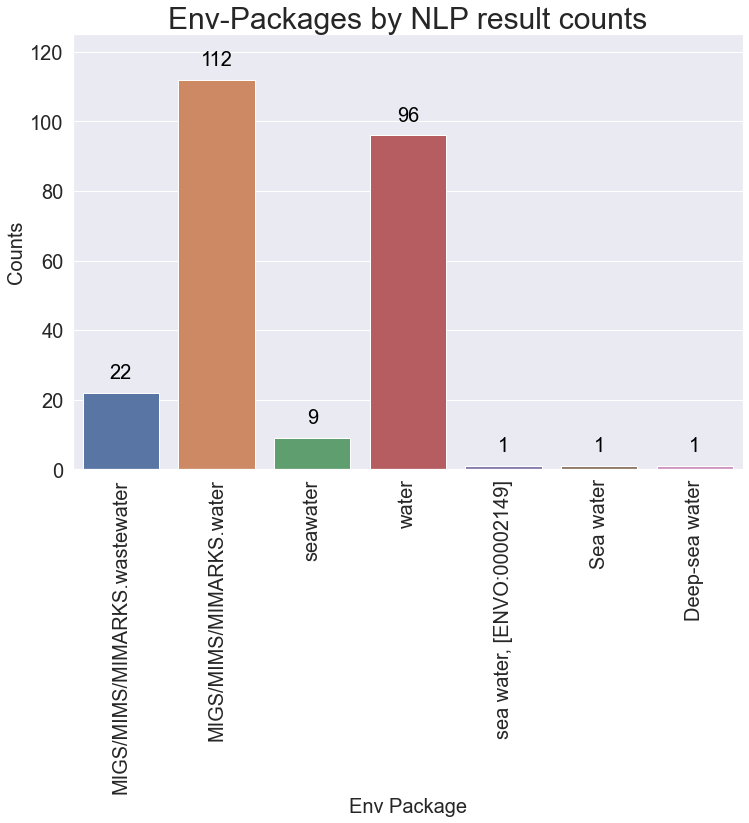

In [52]:
biosamplePackage = result[['BiosampleId', 'env_package']]
biosamplePackage = biosamplePackage.dropna()
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x = biosamplePackage.env_package, data = biosamplePackage)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Env-Packages by NLP result counts', fontsize=30)
ax.set_xlabel("Env Package",fontsize=20)
ax.set_ylabel("Counts",fontsize=20)
ax.tick_params(labelsize=20)

annotatePlot(ax, 125)